# From Demand Forecasts to Capacity Decisions
## Round-03: FedEx Tricolor Capacity Planning

This notebook extends our Round-02 explainable demand forecasting work.
The objective of Round-03 is NOT to re-forecast demand, but to translate
forecasted demand into cost-aware and risk-aware flight capacity decisions
using FedEx Tricolor flight metadata.

Key Principles:
- Forecasts are inputs, not outputs
- Capacity decisions balance cost, risk, and flexibility
- Logic is explainable and planner-friendly


In [10]:
import pandas as pd
import numpy as np

pd.set_option("display.max_columns", None)
pd.set_option("display.width", 120)


In [11]:
# Load Round-02 forecast output
forecast_df = pd.read_csv("../data/forecasted_demand_output.csv")

# Load FedEx Tricolor flight capacity metadata
capacity_df = pd.read_csv("../data/tricolor_flight_capacity.csv")

print("Forecast shape:", forecast_df.shape)
print("Capacity shape:", capacity_df.shape)

forecast_df.head()


Forecast shape: (12000, 14)
Capacity shape: (25, 7)


,customer_id,sku_id,route,time_period,base_demand,promotion_flag,discount_percentage,sentiment_score,review_volume,sustainable_sku_flag,regulation_impact_score,eco_preference_index,forecasted_demand,forecast_confidence
0,CUST_1,SKU_1,DEL-MUM,31-01-2025,71,1,10,0.56,30,0,-0.12,0.06,103,0.87
1,CUST_1,SKU_1,DEL-MUM,28-02-2025,43,0,20,0.94,201,1,0.11,0.61,54,0.86
2,CUST_1,SKU_1,DEL-MUM,31-03-2025,68,0,9,-0.91,197,0,0.03,0.79,60,0.62
3,CUST_1,SKU_1,DEL-MUM,30-04-2025,70,0,19,0.18,140,1,0.14,0.45,76,0.88
4,CUST_1,SKU_1,DEL-MUM,31-05-2025,37,1,27,0.13,274,0,-0.08,0.24,51,0.82


## Input Data Overview

Forecast Data (from Round-02):
- route
- forecasted_demand
- promotion_flag
- forecast_confidence

Flight Capacity Metadata:
- route
- max_capacity
- fixed_operational_cost
- variable_cost_per_unit
- delay_risk_score
- real_time_update_flag

Datasets are joined on route.


In [12]:
planning_df = forecast_df.merge(
    capacity_df,
    on="route",
    how="left"
)

planning_df.head()


,customer_id,sku_id,route,time_period,base_demand,promotion_flag,discount_percentage,sentiment_score,review_volume,sustainable_sku_flag,regulation_impact_score,eco_preference_index,forecasted_demand,forecast_confidence,flight_id,max_capacity,fixed_cost,variable_cost_per_unit,real_time_update_flag,delay_risk_score
0,CUST_1,SKU_1,DEL-MUM,31-01-2025,71,1,10,0.56,30,0,-0.12,0.06,103,0.87,FL_DEL-MUM_1,846,91780,64,0,0.15
1,CUST_1,SKU_1,DEL-MUM,31-01-2025,71,1,10,0.56,30,0,-0.12,0.06,103,0.87,FL_DEL-MUM_2,519,80928,57,0,0.09
2,CUST_1,SKU_1,DEL-MUM,31-01-2025,71,1,10,0.56,30,0,-0.12,0.06,103,0.87,FL_DEL-MUM_3,863,107135,59,0,0.08
3,CUST_1,SKU_1,DEL-MUM,31-01-2025,71,1,10,0.56,30,0,-0.12,0.06,103,0.87,FL_DEL-MUM_4,574,111327,68,1,0.16
4,CUST_1,SKU_1,DEL-MUM,31-01-2025,71,1,10,0.56,30,0,-0.12,0.06,103,0.87,FL_DEL-MUM_5,603,62838,58,0,0.24


In [13]:
def classify_demand_stability(row):
    """
    Rule-based demand stability classification.
    """
    if row["forecast_confidence"] >= 0.7 and row["promotion_flag"] == 0:
        return "Stable"
    return "Volatile"

planning_df["demand_stability"] = planning_df.apply(
    classify_demand_stability, axis=1
)

planning_df[["route", "forecasted_demand", "forecast_confidence", "demand_stability"]].head()


,route,forecasted_demand,forecast_confidence,demand_stability
0,DEL-MUM,103,0.87,Volatile
1,DEL-MUM,103,0.87,Volatile
2,DEL-MUM,103,0.87,Volatile
3,DEL-MUM,103,0.87,Volatile
4,DEL-MUM,103,0.87,Volatile


In [14]:
# ---- Normalize capacity column names to logical names used in decision logic ----

capacity_df = capacity_df.rename(columns={
    "fixed_cost": "fixed_operational_cost"
})

print("Capacity columns after normalization:")
print(capacity_df.columns.tolist())
planning_df = forecast_df.merge(
    capacity_df,
    on="route",
    how="left"
)

planning_df.head()


Capacity columns after normalization:
['flight_id', 'route', 'max_capacity', 'fixed_operational_cost', 'variable_cost_per_unit', 'real_time_update_flag', 'delay_risk_score']


,customer_id,sku_id,route,time_period,base_demand,promotion_flag,discount_percentage,sentiment_score,review_volume,sustainable_sku_flag,regulation_impact_score,eco_preference_index,forecasted_demand,forecast_confidence,flight_id,max_capacity,fixed_operational_cost,variable_cost_per_unit,real_time_update_flag,delay_risk_score
0,CUST_1,SKU_1,DEL-MUM,31-01-2025,71,1,10,0.56,30,0,-0.12,0.06,103,0.87,FL_DEL-MUM_1,846,91780,64,0,0.15
1,CUST_1,SKU_1,DEL-MUM,31-01-2025,71,1,10,0.56,30,0,-0.12,0.06,103,0.87,FL_DEL-MUM_2,519,80928,57,0,0.09
2,CUST_1,SKU_1,DEL-MUM,31-01-2025,71,1,10,0.56,30,0,-0.12,0.06,103,0.87,FL_DEL-MUM_3,863,107135,59,0,0.08
3,CUST_1,SKU_1,DEL-MUM,31-01-2025,71,1,10,0.56,30,0,-0.12,0.06,103,0.87,FL_DEL-MUM_4,574,111327,68,1,0.16
4,CUST_1,SKU_1,DEL-MUM,31-01-2025,71,1,10,0.56,30,0,-0.12,0.06,103,0.87,FL_DEL-MUM_5,603,62838,58,0,0.24


In [15]:
def classify_cost_profile(row):
    """
    Classify cost exposure based on fixed vs variable cost impact.
    """
    fixed_cost = row["fixed_operational_cost"]
    variable_cost_exposure = row["variable_cost_per_unit"] * row["forecasted_demand"]
    
    if fixed_cost >= variable_cost_exposure:
        return "High Fixed Cost Exposure"
    else:
        return "High Variable Cost Exposure"


planning_df["cost_profile"] = planning_df.apply(
    classify_cost_profile, axis=1
)

planning_df[
    [
        "route",
        "fixed_operational_cost",
        "variable_cost_per_unit",
        "forecasted_demand",
        "cost_profile"
    ]
].head()


,route,fixed_operational_cost,variable_cost_per_unit,forecasted_demand,cost_profile
0,DEL-MUM,91780,64,103,High Fixed Cost Exposure
1,DEL-MUM,80928,57,103,High Fixed Cost Exposure
2,DEL-MUM,107135,59,103,High Fixed Cost Exposure
3,DEL-MUM,111327,68,103,High Fixed Cost Exposure
4,DEL-MUM,62838,58,103,High Fixed Cost Exposure


In [16]:
planning_df["delay_risk_flag"] = np.where(
    planning_df["delay_risk_score"] >= 0.3,
    "High Delay Risk",
    "Low Delay Risk"
)

planning_df["flexibility_flag"] = np.where(
    planning_df["real_time_update_flag"] == 1,
    "Flexible",
    "Locked"
)

planning_df[["route", "delay_risk_flag", "flexibility_flag"]].head()


,route,delay_risk_flag,flexibility_flag
0,DEL-MUM,Low Delay Risk,Locked
1,DEL-MUM,Low Delay Risk,Locked
2,DEL-MUM,Low Delay Risk,Locked
3,DEL-MUM,Low Delay Risk,Flexible
4,DEL-MUM,Low Delay Risk,Locked


In [17]:
def classify_demand_stability(row):
    """
    Rule-based demand stability classification.
    """
    if row["forecast_confidence"] >= 0.7 and row["promotion_flag"] == 0:
        return "Stable"
    return "Volatile"

planning_df["demand_stability"] = planning_df.apply(
    classify_demand_stability, axis=1
)

planning_df[["route", "forecasted_demand", "forecast_confidence", "promotion_flag", "demand_stability"]].head()


,route,forecasted_demand,forecast_confidence,promotion_flag,demand_stability
0,DEL-MUM,103,0.87,1,Volatile
1,DEL-MUM,103,0.87,1,Volatile
2,DEL-MUM,103,0.87,1,Volatile
3,DEL-MUM,103,0.87,1,Volatile
4,DEL-MUM,103,0.87,1,Volatile


In [18]:
assert "demand_stability" in planning_df.columns


In [22]:
def decide_utilization_strategy(row):
    """
    Capacity decision logic based on cost, risk, stability, and flexibility.
    """
    if row["delay_risk_flag"] == "High Delay Risk":
        return "Conservative Loading"
    
    if (
        row["demand_stability"] == "Stable"
        and row["cost_profile"] == "High Fixed Cost Exposure"
    ):
        return "Maximize Utilization"
    
    if (
        row["demand_stability"] == "Volatile"
        and row["flexibility_flag"] == "Flexible"
    ):
        return "Dynamic Buffer"
    
    return "Balanced Allocation"


In [23]:
planning_df["utilization_strategy"] = planning_df.apply(
    decide_utilization_strategy, axis=1
)

planning_df[["route", "demand_stability", "utilization_strategy"]].head()


,route,demand_stability,utilization_strategy
0,DEL-MUM,Volatile,Balanced Allocation
1,DEL-MUM,Volatile,Balanced Allocation
2,DEL-MUM,Volatile,Balanced Allocation
3,DEL-MUM,Volatile,Dynamic Buffer
4,DEL-MUM,Volatile,Balanced Allocation


In [24]:
required_cols = [
    "demand_stability",
    "cost_profile",
    "delay_risk_flag",
    "flexibility_flag"
]

for col in required_cols:
    assert col in planning_df.columns, f"Missing column: {col}"

print("All required decision inputs are present.")


All required decision inputs are present.


In [25]:
def generate_planning_comment(row):
    return (
        f"{row['demand_stability']} demand | "
        f"{row['cost_profile']} | "
        f"{row['delay_risk_flag']} | "
        f"{row['flexibility_flag']} → "
        f"{row['utilization_strategy']}"
    )

planning_df["planning_comment"] = planning_df.apply(
    generate_planning_comment, axis=1
)

planning_df[
    ["route", "forecasted_demand", "utilization_strategy", "planning_comment"]
].head()


,route,forecasted_demand,utilization_strategy,planning_comment
0,DEL-MUM,103,Balanced Allocation,Volatile demand | High Fixed Cost Exposure | L...
1,DEL-MUM,103,Balanced Allocation,Volatile demand | High Fixed Cost Exposure | L...
2,DEL-MUM,103,Balanced Allocation,Volatile demand | High Fixed Cost Exposure | L...
3,DEL-MUM,103,Dynamic Buffer,Volatile demand | High Fixed Cost Exposure | L...
4,DEL-MUM,103,Balanced Allocation,Volatile demand | High Fixed Cost Exposure | L...


In [26]:
final_decisions = planning_df[
    [
        "route",
        "forecasted_demand",
        "max_capacity",
        "demand_stability",
        "cost_profile",
        "delay_risk_flag",
        "flexibility_flag",
        "utilization_strategy",
        "planning_comment"
    ]
]

final_decisions.head()


,route,forecasted_demand,max_capacity,demand_stability,cost_profile,delay_risk_flag,flexibility_flag,utilization_strategy,planning_comment
0,DEL-MUM,103,846,Volatile,High Fixed Cost Exposure,Low Delay Risk,Locked,Balanced Allocation,Volatile demand | High Fixed Cost Exposure | L...
1,DEL-MUM,103,519,Volatile,High Fixed Cost Exposure,Low Delay Risk,Locked,Balanced Allocation,Volatile demand | High Fixed Cost Exposure | L...
2,DEL-MUM,103,863,Volatile,High Fixed Cost Exposure,Low Delay Risk,Locked,Balanced Allocation,Volatile demand | High Fixed Cost Exposure | L...
3,DEL-MUM,103,574,Volatile,High Fixed Cost Exposure,Low Delay Risk,Flexible,Dynamic Buffer,Volatile demand | High Fixed Cost Exposure | L...
4,DEL-MUM,103,603,Volatile,High Fixed Cost Exposure,Low Delay Risk,Locked,Balanced Allocation,Volatile demand | High Fixed Cost Exposure | L...


In [27]:
final_decisions.to_csv("round3_capacity_decisions.csv", index=False)
print("Exported: round3_capacity_decisions.csv")


Exported: round3_capacity_decisions.csv


## Conclusion

This notebook demonstrates how explainable demand forecasts can be
translated into cost-aware and risk-aware capacity planning decisions
for the FedEx Tricolor network.

Rather than optimizing blindly, the approach:
- Manages demand uncertainty
- Balances fixed and variable cost exposure
- Protects service reliability
- Produces explainable, planner-ready decisions

This aligns with real-world FedEx operational planning.


In [29]:
import pandas as pd

round3_capacity_decisions = pd.read_csv(
    "../data/round3_capacity_decisions.csv"
)

round3_capacity_decisions.head()


,route,forecasted_demand,max_capacity,demand_stability,cost_profile,delay_risk_flag,flexibility_flag,utilization_strategy,planning_comment
0,DEL-MUM,103,846,Volatile,High Fixed Cost Exposure,Low Delay Risk,Locked,Balanced Allocation,Volatile demand | High Fixed Cost Exposure | L...
1,DEL-MUM,103,519,Volatile,High Fixed Cost Exposure,Low Delay Risk,Locked,Balanced Allocation,Volatile demand | High Fixed Cost Exposure | L...
2,DEL-MUM,103,863,Volatile,High Fixed Cost Exposure,Low Delay Risk,Locked,Balanced Allocation,Volatile demand | High Fixed Cost Exposure | L...
3,DEL-MUM,103,574,Volatile,High Fixed Cost Exposure,Low Delay Risk,Flexible,Dynamic Buffer,Volatile demand | High Fixed Cost Exposure | L...
4,DEL-MUM,103,603,Volatile,High Fixed Cost Exposure,Low Delay Risk,Locked,Balanced Allocation,Volatile demand | High Fixed Cost Exposure | L...


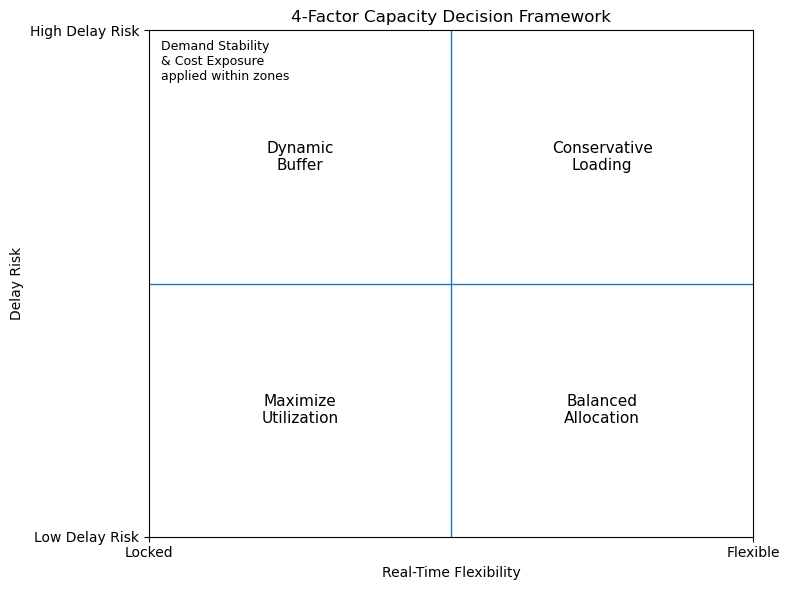

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

# Draw quadrant lines
plt.axhline(0.5, linewidth=1)
plt.axvline(0.5, linewidth=1)

# Quadrant labels (Utilization Strategies)
plt.text(0.75, 0.75, "Conservative\nLoading",
         ha="center", va="center", fontsize=11)

plt.text(0.25, 0.75, "Dynamic\nBuffer",
         ha="center", va="center", fontsize=11)

plt.text(0.75, 0.25, "Balanced\nAllocation",
         ha="center", va="center", fontsize=11)

plt.text(0.25, 0.25, "Maximize\nUtilization",
         ha="center", va="center", fontsize=11)

# Axis formatting
plt.xticks([0, 1], ["Locked", "Flexible"])
plt.yticks([0, 1], ["Low Delay Risk", "High Delay Risk"])

plt.xlabel("Real-Time Flexibility")
plt.ylabel("Delay Risk")
plt.title("4-Factor Capacity Decision Framework")

# Factor annotations
plt.text(0.02, 0.98, "Demand Stability\n& Cost Exposure\napplied within zones",
         fontsize=9, va="top")

plt.grid(False)
plt.tight_layout()
plt.show()


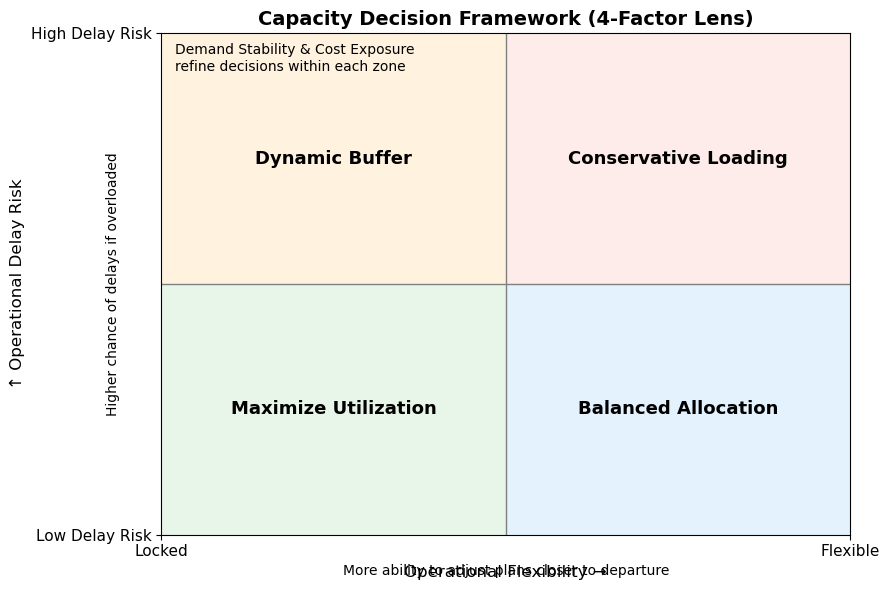

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 6))

# Background zones
plt.fill_between([0, 0.5], 0.5, 1, color="#FFF3E0")  # Dynamic Buffer
plt.fill_between([0.5, 1], 0.5, 1, color="#FDECEA")  # Conservative
plt.fill_between([0, 0.5], 0, 0.5, color="#E8F5E9")  # Maximize
plt.fill_between([0.5, 1], 0, 0.5, color="#E3F2FD")  # Balanced

# Quadrant lines
plt.axhline(0.5, color="gray", linewidth=1)
plt.axvline(0.5, color="gray", linewidth=1)

# Strategy labels
plt.text(0.25, 0.75, "Dynamic Buffer",
         ha="center", va="center", fontsize=13, weight="bold")

plt.text(0.75, 0.75, "Conservative Loading",
         ha="center", va="center", fontsize=13, weight="bold")

plt.text(0.25, 0.25, "Maximize Utilization",
         ha="center", va="center", fontsize=13, weight="bold")

plt.text(0.75, 0.25, "Balanced Allocation",
         ha="center", va="center", fontsize=13, weight="bold")

# Axis ticks (minimal)
plt.xticks([0, 1], ["Locked", "Flexible"], fontsize=11)
plt.yticks([0, 1], ["Low Delay Risk", "High Delay Risk"], fontsize=11)

# Axis titles
plt.xlabel("Operational Flexibility →", fontsize=12)
plt.ylabel("↑ Operational Delay Risk", fontsize=12)

# Directional explanations (THIS IS THE KEY FIX)
plt.text(0.5, -0.08, "More ability to adjust plans closer to departure",
         ha="center", fontsize=10)

plt.text(-0.08, 0.5, "Higher chance of delays if overloaded",
         va="center", rotation=90, fontsize=10)

# Framework title
plt.title("Capacity Decision Framework (4-Factor Lens)",
          fontsize=14, weight="bold")

# Other factor note
plt.text(
    0.02, 0.98,
    "Demand Stability & Cost Exposure\nrefine decisions within each zone",
    fontsize=10,
    va="top"
)

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.tight_layout()
plt.show()


C:\Users\Partha\AppData\Local\Temp\ipykernel_22152\3625778062.py:64: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
C:\Users\Partha\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


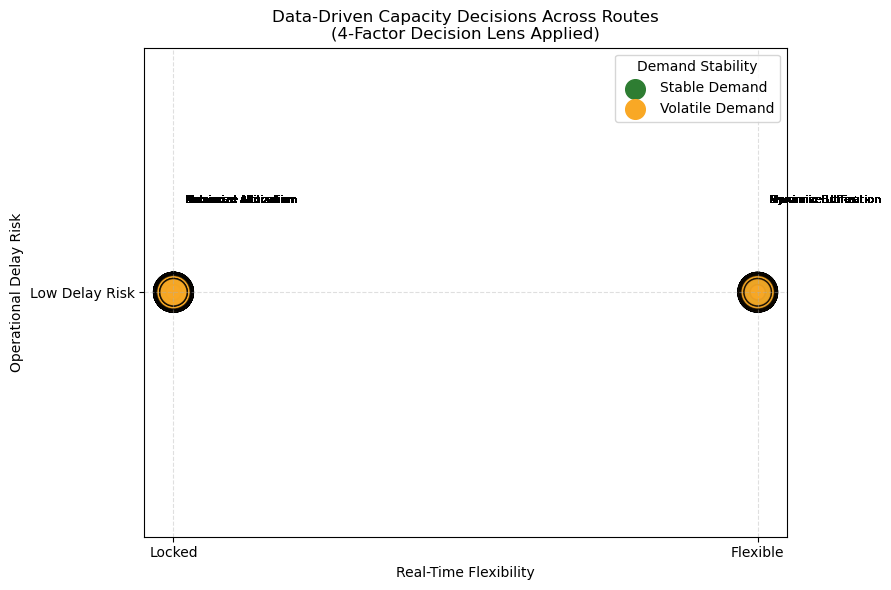

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

# Load decision output
df = pd.read_csv("../data/round3_capacity_decisions.csv")

# Encode axes numerically
df["flex_num"] = df["flexibility_flag"].map({
    "Locked": 0,
    "Flexible": 1
})

df["risk_num"] = df["delay_risk_flag"].map({
    "Low Delay Risk": 0,
    "High Delay Risk": 1
})

# Color by demand stability
color_map = {
    "Stable": "#2E7D32",     # green
    "Volatile": "#F9A825"    # amber
}

df["stability_color"] = df["demand_stability"].map(color_map)

# Bubble size by forecasted demand
df["bubble_size"] = df["forecasted_demand"] * 5  # scale for visibility

plt.figure(figsize=(9, 6))

plt.scatter(
    df["flex_num"],
    df["risk_num"],
    s=df["bubble_size"],
    c=df["stability_color"],
    alpha=0.75,
    edgecolor="black"
)

# Annotate utilization strategy
for _, row in df.iterrows():
    plt.text(
        row["flex_num"] + 0.02,
        row["risk_num"] + 0.02,
        row["utilization_strategy"],
        fontsize=8
    )

# Axes
plt.xticks([0, 1], ["Locked", "Flexible"])
plt.yticks([0, 1], ["Low Delay Risk", "High Delay Risk"])

plt.xlabel("Real-Time Flexibility")
plt.ylabel("Operational Delay Risk")

plt.title("Data-Driven Capacity Decisions Across Routes\n(4-Factor Decision Lens Applied)")

# Legend (manual)
plt.scatter([], [], s=200, c="#2E7D32", label="Stable Demand")
plt.scatter([], [], s=200, c="#F9A825", label="Volatile Demand")
plt.legend(title="Demand Stability")

plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


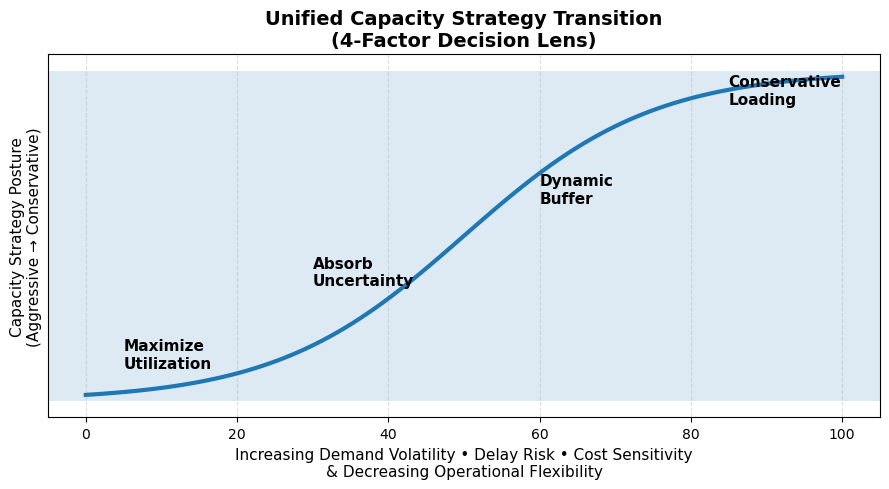

In [39]:
import matplotlib.pyplot as plt
import numpy as np

# X-axis: Combined Operational Uncertainty Index (conceptual)
x = np.linspace(0, 100, 100)

# Strategy transition curve
# Lower values → aggressive, higher → conservative
y = 1 / (1 + np.exp(-0.08 * (x - 50)))  # smooth transition

plt.figure(figsize=(9, 5))

plt.plot(x, y, linewidth=3)

# Strategy bands
plt.axhspan(0.0, 0.25, alpha=0.15)
plt.axhspan(0.25, 0.5, alpha=0.15)
plt.axhspan(0.5, 0.75, alpha=0.15)
plt.axhspan(0.75, 1.0, alpha=0.15)

# Strategy labels
plt.text(5, 0.1, "Maximize\nUtilization", fontsize=11, weight="bold")
plt.text(30, 0.35, "Absorb\nUncertainty", fontsize=11, weight="bold")
plt.text(60, 0.6, "Dynamic\nBuffer", fontsize=11, weight="bold")
plt.text(85, 0.9, "Conservative\nLoading", fontsize=11, weight="bold")

# Axis labels
plt.xlabel(
    "Increasing Demand Volatility • Delay Risk • Cost Sensitivity\n& Decreasing Operational Flexibility",
    fontsize=11
)
plt.ylabel("Capacity Strategy Posture\n(Aggressive → Conservative)", fontsize=11)

# Title
plt.title(
    "Unified Capacity Strategy Transition\n(4-Factor Decision Lens)",
    fontsize=14,
    weight="bold"
)

plt.yticks([])
plt.grid(axis="x", linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()


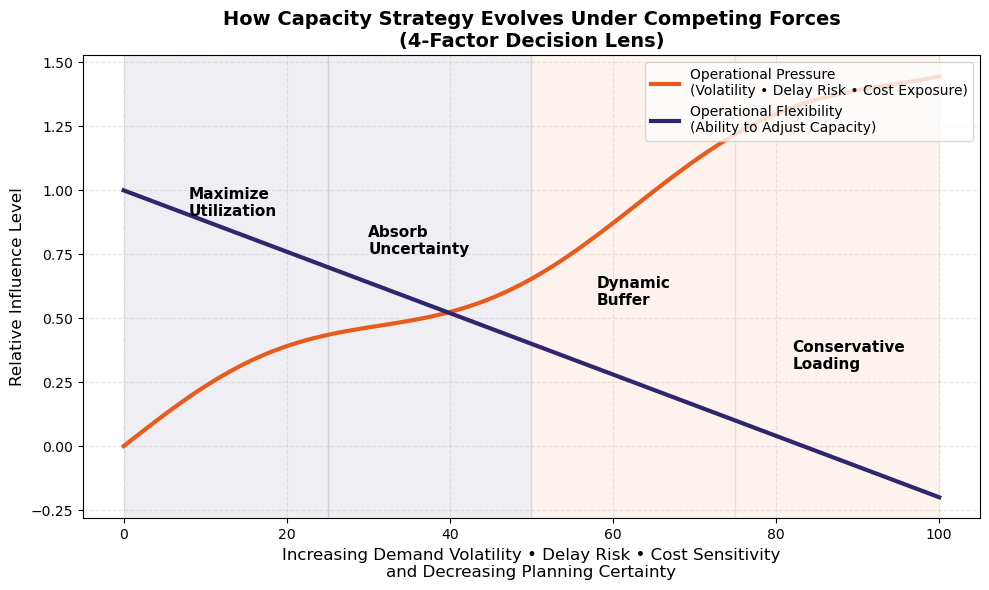

In [40]:
import matplotlib.pyplot as plt
import numpy as np

# X-axis: Planning horizon / increasing uncertainty
x = np.linspace(0, 100, 100)

# Line 1: Operational Pressure (volatility + delay risk + cost)
pressure = 0.015 * x + 0.1 * np.sin(x / 10)

# Line 2: Operational Flexibility (ability to adapt)
flexibility = 1 - (0.012 * x)

plt.figure(figsize=(10, 6))

# Plot lines using your PPT theme colors
plt.plot(
    x, pressure,
    color="#e95b1c",
    linewidth=3,
    label="Operational Pressure\n(Volatility • Delay Risk • Cost Exposure)"
)

plt.plot(
    x, flexibility,
    color="#2e276c",
    linewidth=3,
    label="Operational Flexibility\n(Ability to Adjust Capacity)"
)

# Strategy zones (horizontal bands)
plt.axvspan(0, 25, alpha=0.08, color="#2e276c")
plt.axvspan(25, 50, alpha=0.08, color="#2e276c")
plt.axvspan(50, 75, alpha=0.08, color="#e95b1c")
plt.axvspan(75, 100, alpha=0.08, color="#e95b1c")

# Strategy labels
plt.text(8, 0.9, "Maximize\nUtilization", fontsize=11, weight="bold")
plt.text(30, 0.75, "Absorb\nUncertainty", fontsize=11, weight="bold")
plt.text(58, 0.55, "Dynamic\nBuffer", fontsize=11, weight="bold")
plt.text(82, 0.3, "Conservative\nLoading", fontsize=11, weight="bold")

# Axis labels
plt.xlabel(
    "Increasing Demand Volatility • Delay Risk • Cost Sensitivity\nand Decreasing Planning Certainty",
    fontsize=12
)
plt.ylabel("Relative Influence Level", fontsize=12)

# Title
plt.title(
    "How Capacity Strategy Evolves Under Competing Forces\n(4-Factor Decision Lens)",
    fontsize=14,
    weight="bold"
)

# Legend
plt.legend(loc="upper right")

plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()


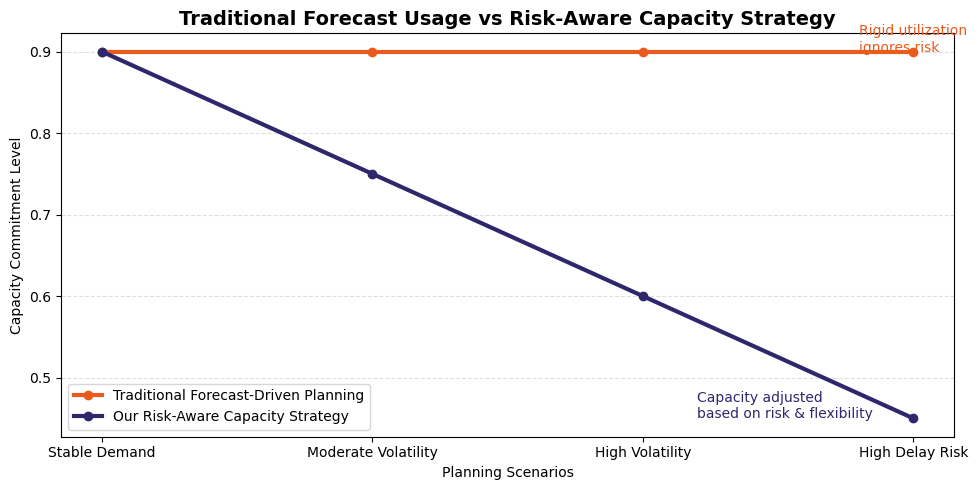

In [43]:
import matplotlib.pyplot as plt
import numpy as np

# Planning scenarios
scenarios = [
    "Stable Demand",
    "Moderate Volatility",
    "High Volatility",
    "High Delay Risk"
]

x = np.arange(len(scenarios))

# Capacity commitment levels (conceptual scale)
# Higher = more capacity committed
traditional = [0.9, 0.9, 0.9, 0.9]   # Forecast = target everywhere
strategy = [0.9, 0.75, 0.6, 0.45]    # Risk-aware adjustment

plt.figure(figsize=(10, 5))

plt.plot(
    x, traditional,
    marker="o",
    linewidth=3,
    color="#e95b1c",
    label="Traditional Forecast-Driven Planning"
)

plt.plot(
    x, strategy,
    marker="o",
    linewidth=3,
    color="#2e276c",
    label="Our Risk-Aware Capacity Strategy"
)

# Axis labels
plt.xticks(x, scenarios)
plt.ylabel("Capacity Commitment Level")
plt.xlabel("Planning Scenarios")

# Title
plt.title(
    "Traditional Forecast Usage vs Risk-Aware Capacity Strategy",
    fontsize=14,
    weight="bold"
)

# Annotations
plt.text(2.8, 0.9, "Rigid utilization\nignores risk", color="#e95b1c")
plt.text(2.2, 0.45, "Capacity adjusted\nbased on risk & flexibility", color="#2e276c")

plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()
